In [1]:
import numpy as np
import pandas as pd 
import torch 
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import shap

In [2]:
X, y = make_regression(n_samples=10000, n_features=10, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1)
y_test_tensor = torch.from_numpy(y_test).float().view(-1, 1) 

feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

In [3]:
class SimpleNN(torch.nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.linear1 = torch.nn.Linear(10, 10)
        self.linear2 = torch.nn.Linear(10, 1)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [4]:
model = SimpleNN()

In [5]:
criteria = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [6]:
for epoch in range(500):
    # Forward pass
    y_pred = model(X_train_tensor)
    
    # Compute Loss
    loss = criteria(y_pred, y_train_tensor)
    if epoch % 100 == 0:
        print(f'Epoch {epoch} | Loss: {loss.item():.4f}')
    
    # Zero gradients, backward pass, update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0 | Loss: 36358.7422
Epoch 100 | Loss: 26577.3223
Epoch 200 | Loss: 8218.2354
Epoch 300 | Loss: 1654.9196
Epoch 400 | Loss: 512.3287


In [7]:
with torch.no_grad():
    y_pred = model(X_test_tensor)
    loss = criteria(y_pred, y_test_tensor)
    print(f'Final Loss: {loss.item():.4f}')

Final Loss: 306.6820


In [8]:
# Prepare data for SHAP
n_background_samples = 100
background = X_test_tensor
background = background[np.random.choice(background.shape[0], n_background_samples, replace=False)]
explained = X_test_tensor[np.random.choice(X_test_tensor.shape[0], 100, replace=False)]

# Initialize explainer object
exp = shap.DeepExplainer(model, background)
shap_values = exp.shap_values(explained)
base_values = np.tile(exp.expected_value, (shap_values.shape[0], 1))

In [9]:
# Create explanation object
explanation = shap.Explanation(values=shap_values,
                               data=explained.numpy(),
                               base_values=base_values,
                               feature_names=feature_names)

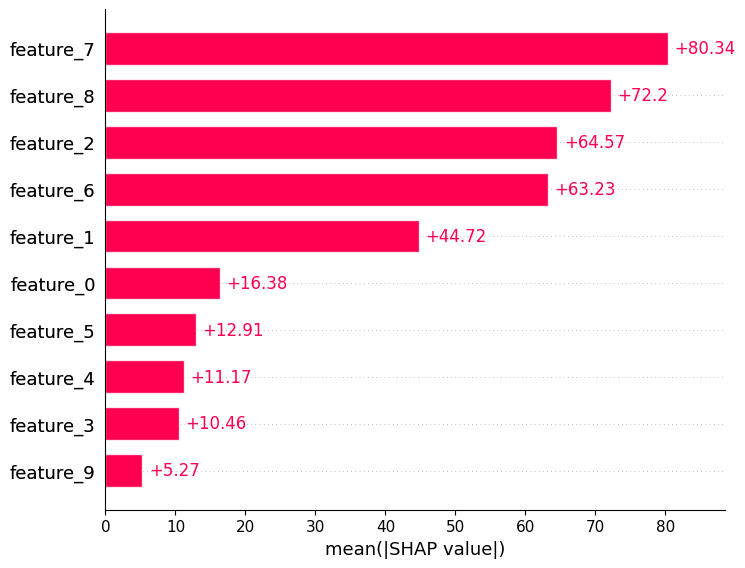

In [10]:
shap.plots.bar(explanation)

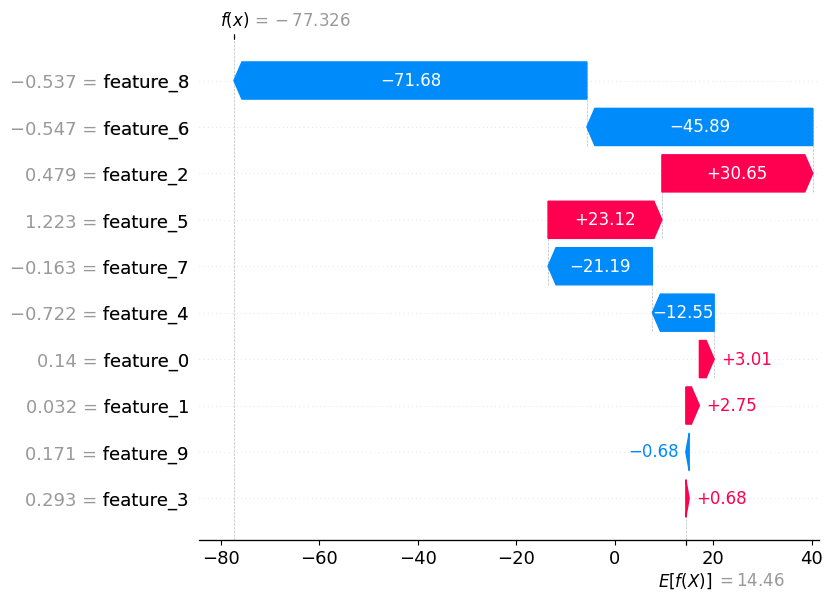

In [11]:
shap.plots.waterfall(explanation[0])

In [12]:
shap.initjs()
shap.plots.force(explanation[0])

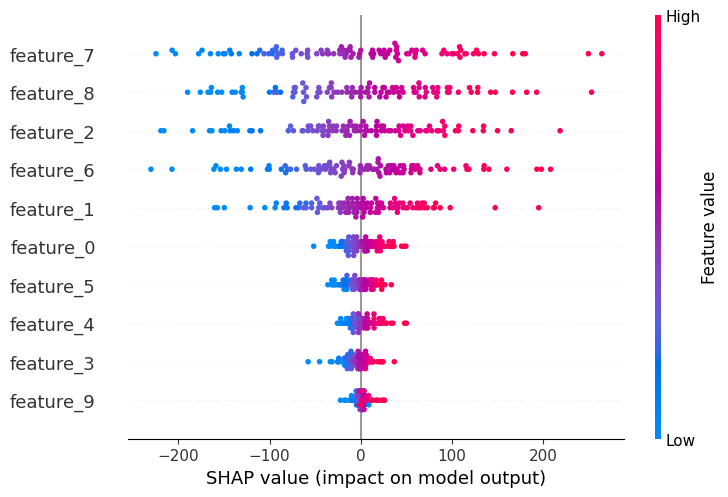

In [13]:
shap.plots.beeswarm(explanation)

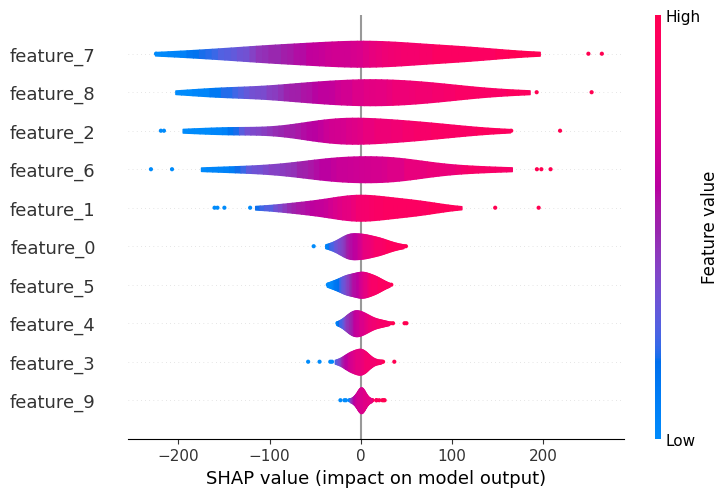

In [14]:
shap.plots.violin(explanation)

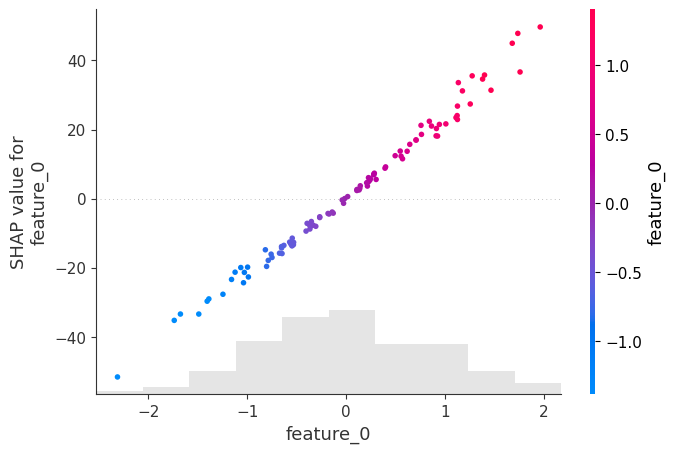

In [15]:
shap.plots.scatter(shap_values=explanation[:, 0], 
                   color=explanation[:, 0]
                #    color=explanation[:, 1]
                   )